# Time Series AWS

## Intro
* **Date**: 1/4/2021
* **What**: I'm doing the time-series mwta network again, but this time I'm doing it on the p-instance with aws and CuPy, so I'm going to train a bunch more neurons on it, and see what I can get.  
* **Why**: I want to get a feel (and the code down) for doing time-series on AWS before I start going to town with the invariant layer, so this is a super good way to get the feel for it.
* **Hopes**: I'm probably going to train 2,500-10,000 neurons on the tapestry, and I would simply love it if my reconstructions were just incredibly good.
* **Limitations**: Unlike the brain, I can't just conjure up 100,000 sparse neurons for every incoming 14 neurons, the reconstructions might not be fantastic, even with more neurons.  I guess it just remains to be seen how good I can get it.

## Code

In [29]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

(x_tr, _), _ = mnist.load_data()

x_tr = x_tr / 255.0

t_sl = 30 # Tapestry side length
m_sl = 28 # Side length of each images

tapestry = np.zeros((t_sl * m_sl, t_sl * m_sl))

x_i = 3000

for x in range(t_sl):
    for y in range(t_sl):

        tapestry[y * m_sl : (y + 1) * m_sl, x * m_sl : (x + 1) * m_sl] = x_tr[x_i]
        x_i += 1
        
tapestry[(t_sl - 1) * m_sl:, :] = tapestry[: m_sl, :]
tapestry[:, (t_sl - 1) * m_sl:] = tapestry[:, : m_sl]

def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

<IPython.core.display.Javascript object>


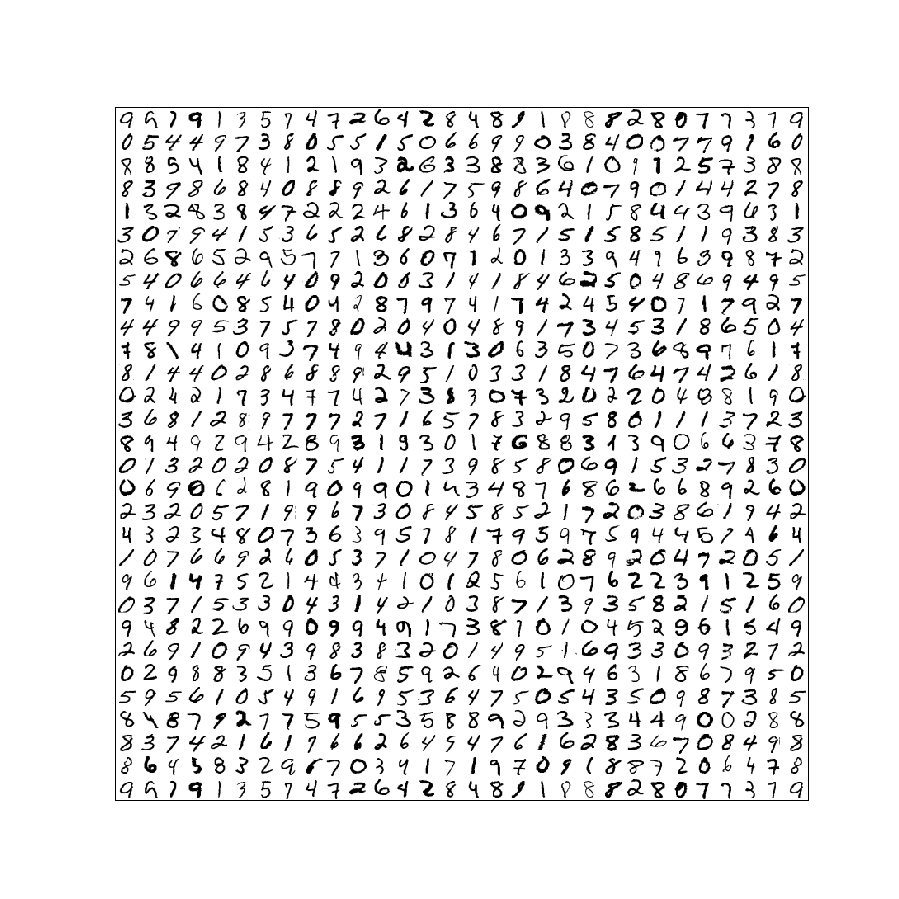

In [30]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(tapestry, cmap="gray_r")

In [31]:
x_o = 420
y_o = 420

sl = 20

x = x_o
y = y_o

v_x = 0
v_y = 0

v_max = 3

a_x = np.random.uniform(-1, 1)
a_y = np.random.uniform(-1, 1)

img_count = 100_000
imgs = []

del_t = 1

for i in range(img_count):
    if i % 20 == 0:
        a_x = np.random.uniform(-1, 1)
        a_y = np.random.uniform(-1, 1)
        
    x += v_x * del_t
    y += v_y * del_t
    v_x = np.clip(v_x + (a_x * del_t), -v_max, v_max)
    v_y = np.clip(v_y + (a_y * del_t), -v_max, v_max)
    
    x_f = int(x) % ((t_sl - 1) * m_sl)
    y_f = int(y) % ((t_sl - 1) * m_sl)
    
    imgs.append(tapestry[y_f: y_f + sl, x_f : x_f + sl])
    
img_array = np.array(imgs)
ts_data = img_array.reshape(-1, sl ** 2)
gp_data = cp.asarray(ts_data)

<IPython.core.display.Javascript object>


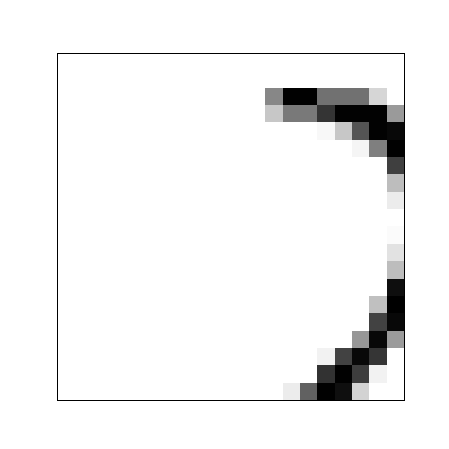

In [7]:
%matplotlib notebook
fig = plt.figure(figsize=(5, 5))

ims = []
for i in range(500):
    im = plt.imshow(imgs[i], cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])
plt.show()

Shoot, the fact that I'm doing this over an internet connection isn't great for the animations.  It took awhile for that to play properly.  Anyway, food for thought.

Edit: Here's another validation tapestry and time-series dataset.

In [24]:
tap_val = np.zeros((t_sl * m_sl, t_sl * m_sl))

x_i = 1000

for x in range(t_sl):
    for y in range(t_sl):

        tap_val[y * m_sl : (y + 1) * m_sl, x * m_sl : (x + 1) * m_sl] = x_tr[x_i]
        x_i += 1
        
tap_val[(t_sl - 1) * m_sl:, :] = tap_val[: m_sl, :]
tap_val[:, (t_sl - 1) * m_sl:] = tap_val[:, : m_sl]

<IPython.core.display.Javascript object>


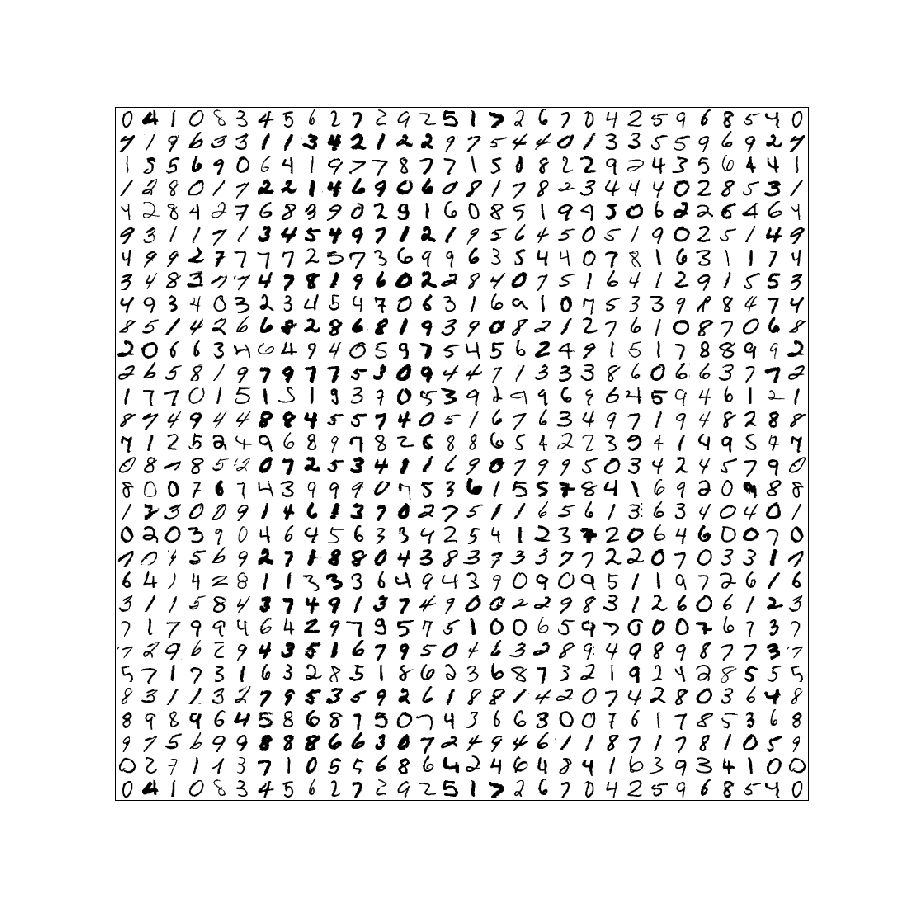

In [25]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(tap_val, cmap="gray_r")

In [26]:
x_o = 420
y_o = 420

sl = 20

x = x_o
y = y_o

v_x = 0
v_y = 0

v_max = 3

a_x = np.random.uniform(-1, 1)
a_y = np.random.uniform(-1, 1)

img_count = 10_000
imgs = []

del_t = 1

for i in range(img_count):
    if i % 20 == 0:
        a_x = np.random.uniform(-1, 1)
        a_y = np.random.uniform(-1, 1)
        
    x += v_x * del_t
    y += v_y * del_t
    v_x = np.clip(v_x + (a_x * del_t), -v_max, v_max)
    v_y = np.clip(v_y + (a_y * del_t), -v_max, v_max)
    
    x_f = int(x) % ((t_sl - 1) * m_sl)
    y_f = int(y) % ((t_sl - 1) * m_sl)
    
    imgs.append(tapestry[y_f: y_f + sl, x_f : x_f + sl])
    
img_array = np.array(imgs)
ts_val = img_array.reshape(-1, sl ** 2)
gp_val = cp.asarray(ts_data)

## Analysis Dialog

Ok, I'm taking this straight from the Time-series MWTA experiment, except that I'm replacing np with cp, and we're going to boost the number of neurons.

<IPython.core.display.Javascript object>


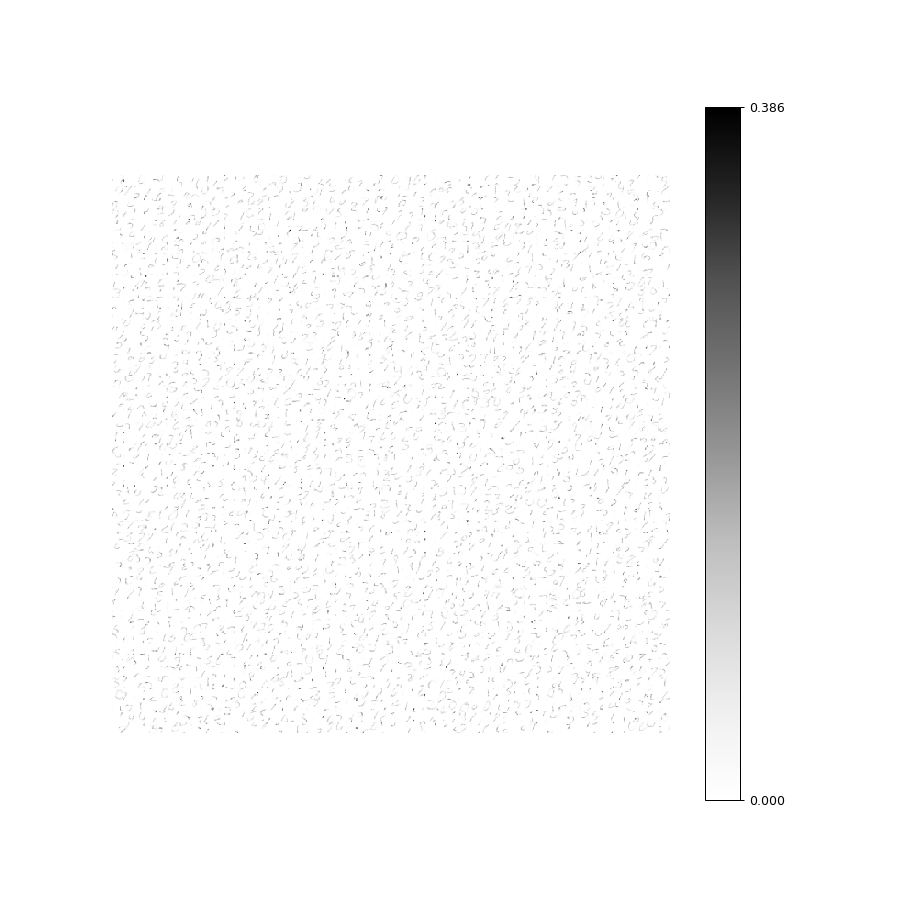

100%|██████████| 10000/10000 [00:05<00:00, 1837.16it/s]


In [9]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 50
Ky = 50
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = cp.random.uniform(0, 0.4, (N, m_len))
xi = 0.02

for ep in range(Nep):
    inputs = gp_data
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 1000 == 0:
            w = cp.maximum(w, 0)
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

Ok, looking good so far.  Let's see how the animation looks.

<IPython.core.display.Javascript object>


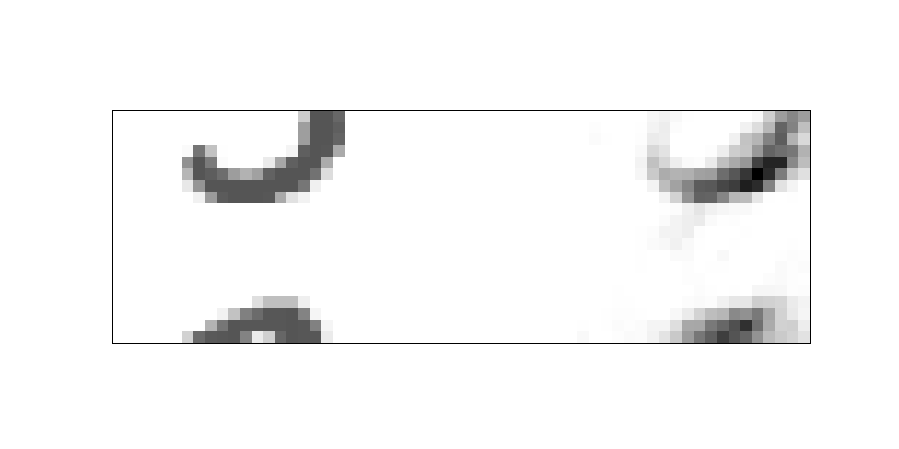

100%|██████████| 500/500 [00:01<00:00, 471.39it/s]


In [15]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

w_np = w.get()

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w_np.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:20, :20] = v.reshape(20, 20)
    mini_tap[:20, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Ok, that's pretty incredible.  I'm going to bump the neuron count up to 10,000 neurons, and we're going to try that again.  After that, I'm probably going to do 10 winners and see how it looks.

Or even 8 winners would also be good.

<IPython.core.display.Javascript object>


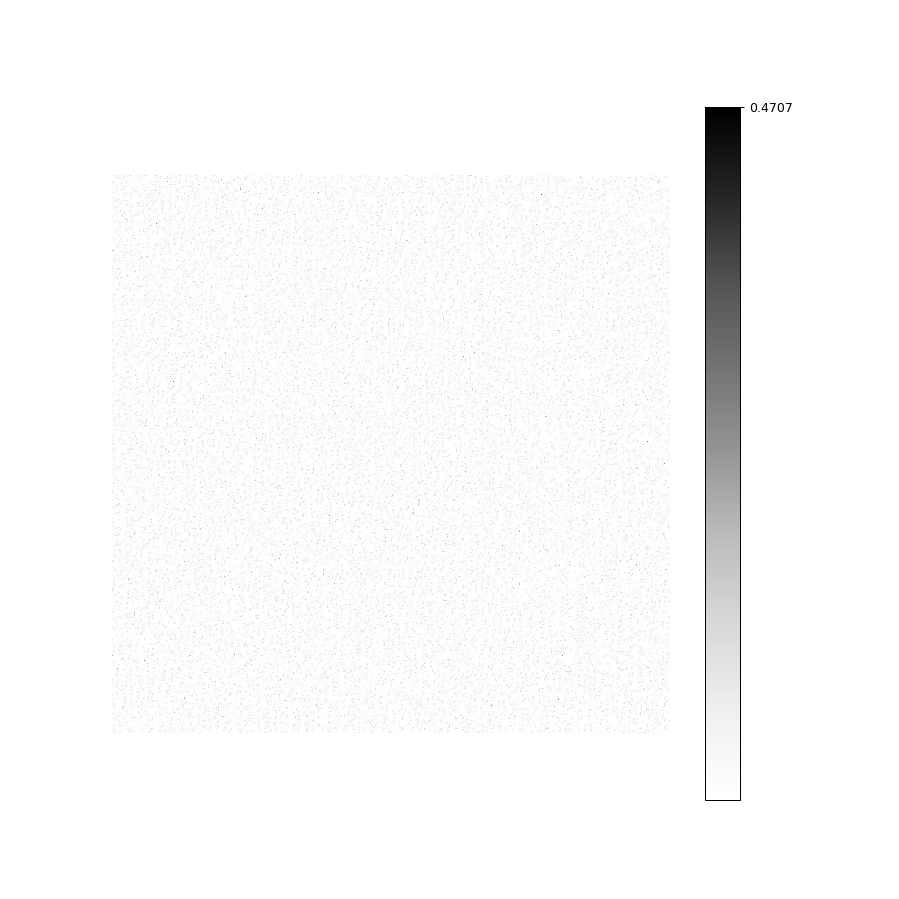

100%|██████████| 10000/10000 [00:08<00:00, 1239.81it/s]


In [16]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 100
Ky = 100
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = cp.random.uniform(0, 0.4, (N, m_len))
xi = 0.02

for ep in range(Nep):
    inputs = gp_data
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 1000 == 0:
            w = cp.maximum(w, 0)
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


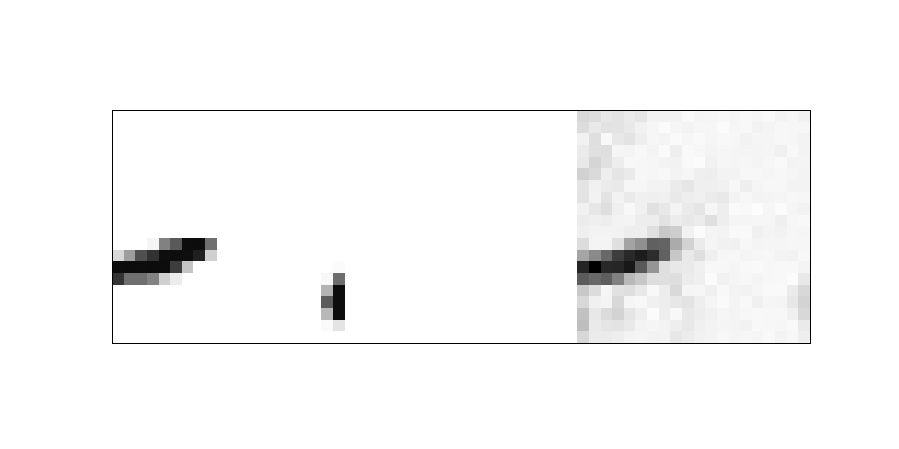

100%|██████████| 500/500 [00:02<00:00, 224.90it/s]


In [17]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

w_np = w.get()

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w_np.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:20, :20] = v.reshape(20, 20)
    mini_tap[:20, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Shoot dang.  That's *really, really* good.  It's clear that some of the neurons weren't trained enough, so I'm going to bump up the learning constant and try again.

I also realize that I should probably also use a different tapestry for viewing the final animation, because with this many neurons, it's not infeasible that the network is actually just memorizing.  But whatever.  Here's bigger `xi`.

<IPython.core.display.Javascript object>


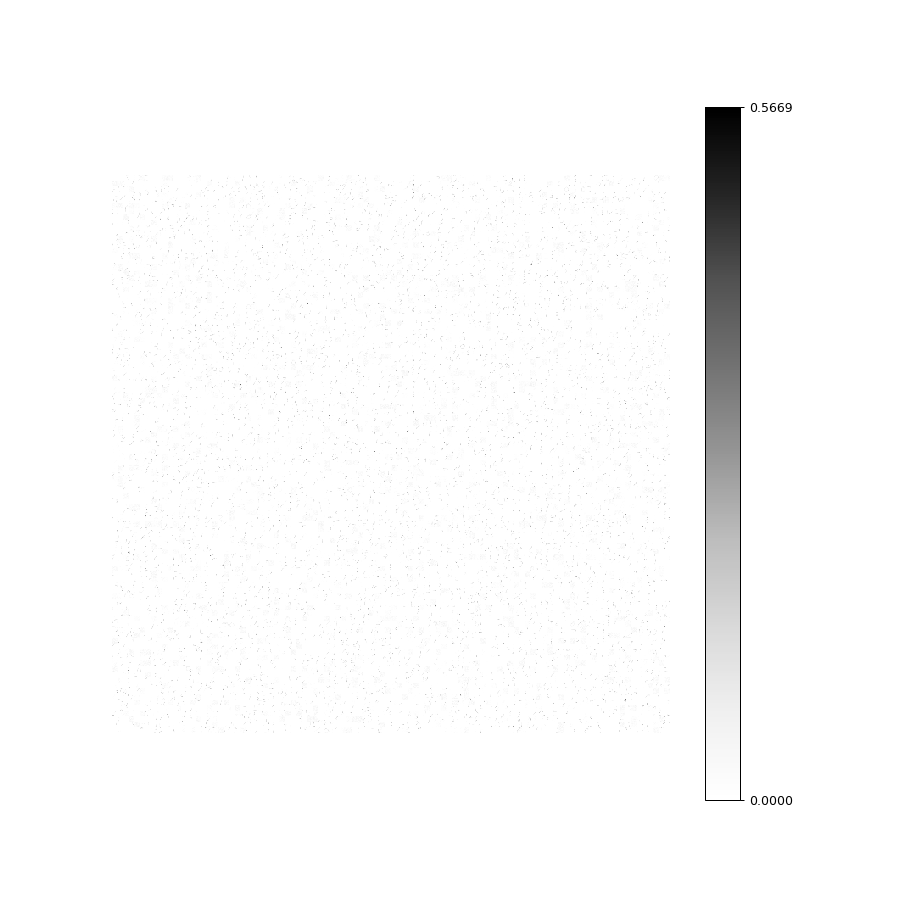

100%|██████████| 10000/10000 [00:07<00:00, 1258.63it/s]


In [18]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 100
Ky = 100
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = cp.random.uniform(0, 0.4, (N, m_len))
xi = 0.08

for ep in range(Nep):
    inputs = gp_data
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 1000 == 0:
            w = cp.maximum(w, 0)
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


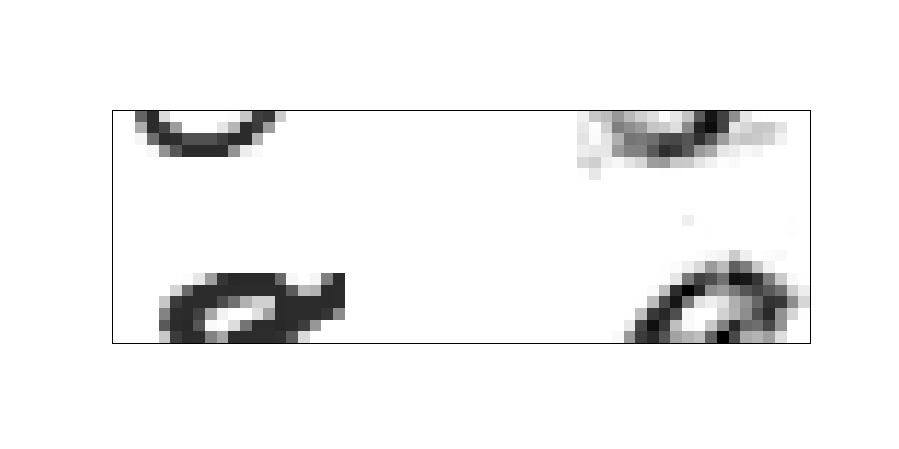

100%|██████████| 500/500 [00:01<00:00, 273.01it/s]


In [19]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

w_np = w.get()

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w_np.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:20, :20] = v.reshape(20, 20)
    mini_tap[:20, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Ok, that's definitely super good, but it isn't actually as good as the last one.  I actually think the learning constant was too high.  I'm going to take it down for one final run.  I'm then going to cook up a new dataset.

<IPython.core.display.Javascript object>


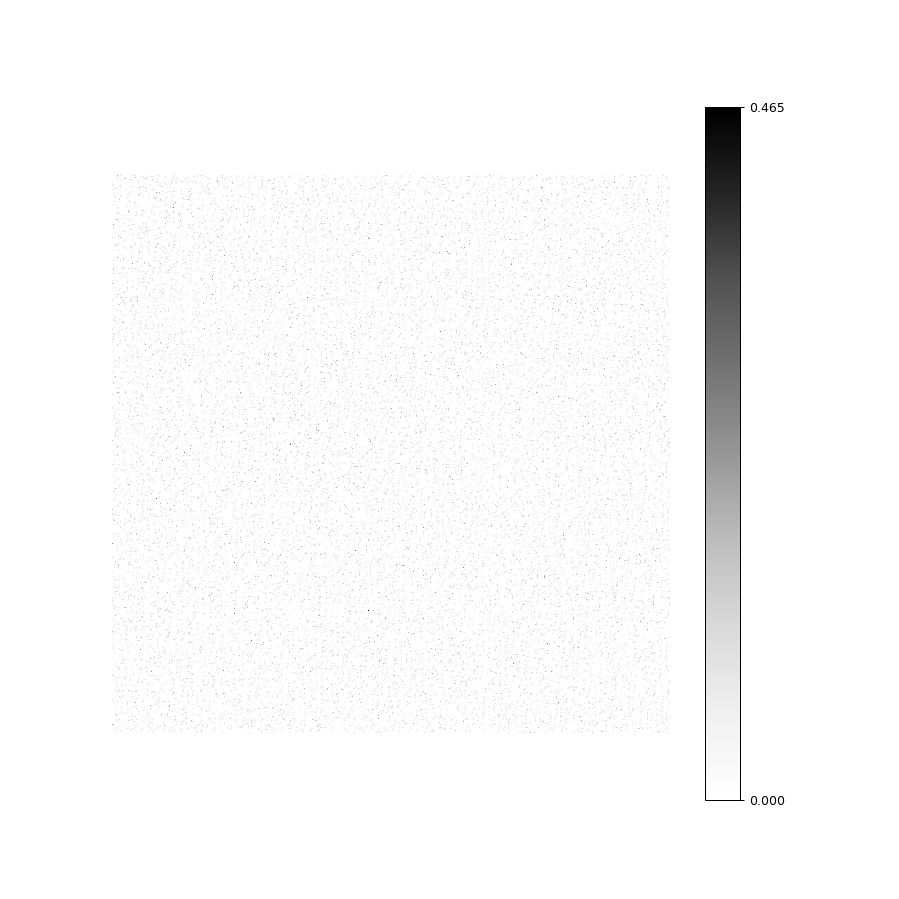

100%|██████████| 10000/10000 [00:07<00:00, 1258.21it/s]


In [22]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 100
Ky = 100
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = cp.random.uniform(0, 0.2, (N, m_len))
xi = 0.05

for ep in range(Nep):
    inputs = gp_data
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


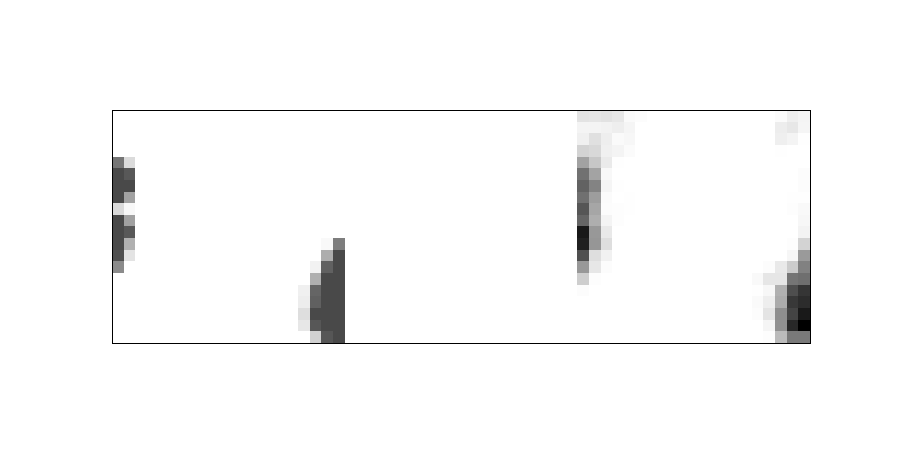

100%|██████████| 500/500 [00:02<00:00, 247.54it/s]


In [23]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

w_np = w.get()

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w_np.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:20, :20] = v.reshape(20, 20)
    mini_tap[:20, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Ok, that's pretty crazy good.  I'm much happy with this.  I'm going to create another tapestry and dataset at the top, and then validate these reconstructions on novel data.

<IPython.core.display.Javascript object>


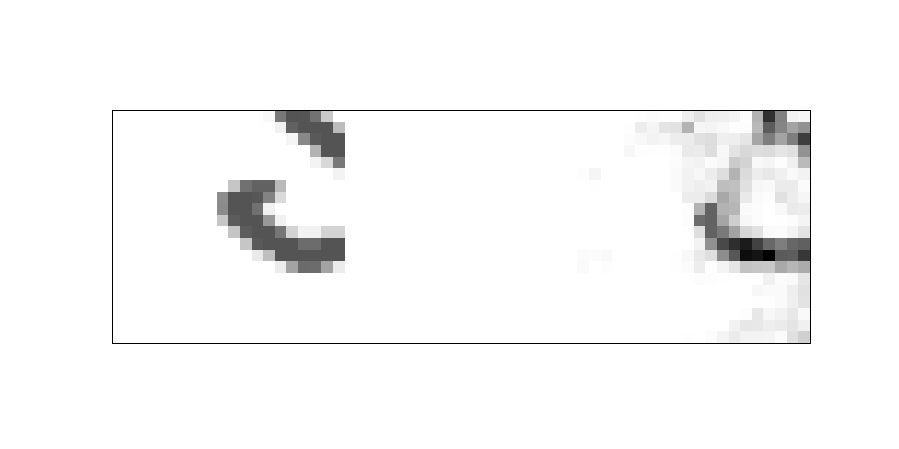

100%|██████████| 500/500 [00:02<00:00, 237.07it/s]


In [27]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

w_np = w.get()

ims = []
for i in tqdm(range(500)):
    v = ts_val[i].reshape(-1, 1)
    p = w_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w_np.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:20, :20] = v.reshape(20, 20)
    mini_tap[:20, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

It's still pretty remarkably good.  I have an idea.  I'm going to make the training dataset 10x larger, and train on that instead of several epochs.

<IPython.core.display.Javascript object>


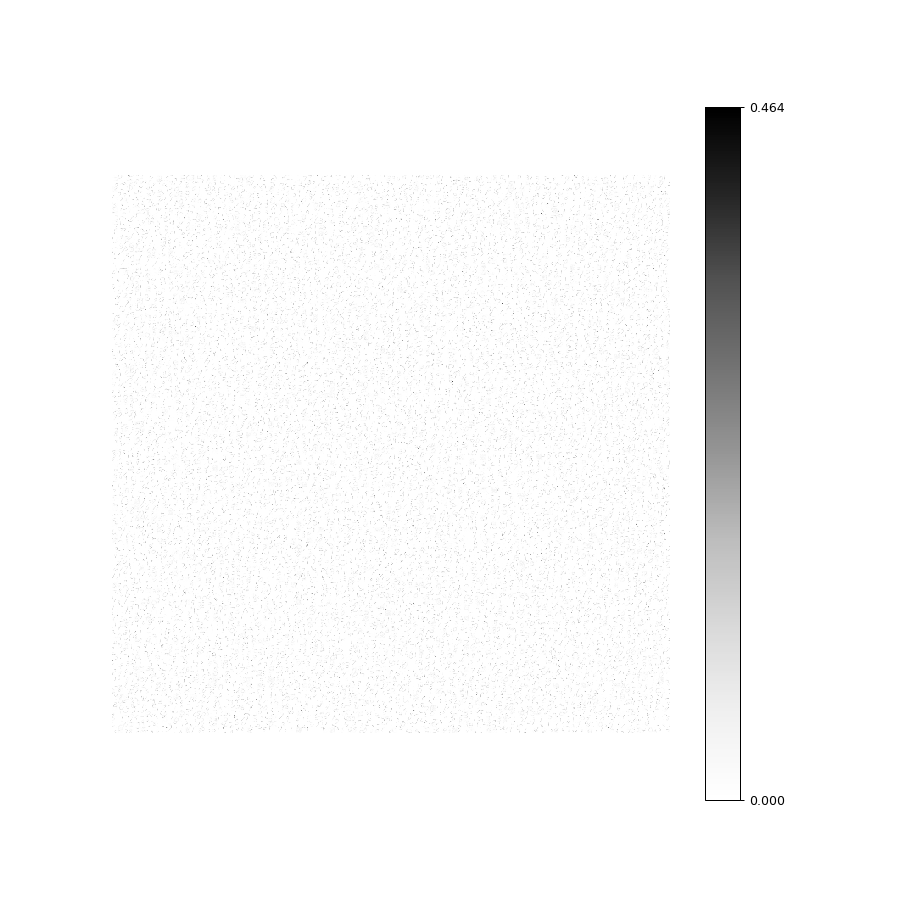

100%|██████████| 100000/100000 [01:20<00:00, 1239.13it/s]


In [32]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 1
T_s = 100_000

Kx = 100
Ky = 100
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 5 #Number of winners

# Feedforward
w = cp.random.uniform(0, 0.2, (N, m_len))
xi = 0.05

for ep in range(Nep):
    inputs = gp_data
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


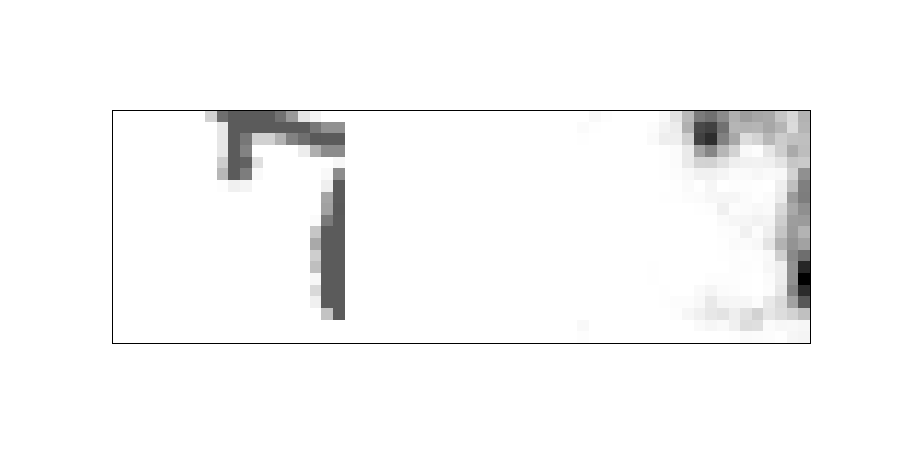

100%|██████████| 500/500 [00:01<00:00, 254.22it/s]


In [33]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

w_np = w.get()

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w_np.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:20, :20] = v.reshape(20, 20)
    mini_tap[:20, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

<IPython.core.display.Javascript object>


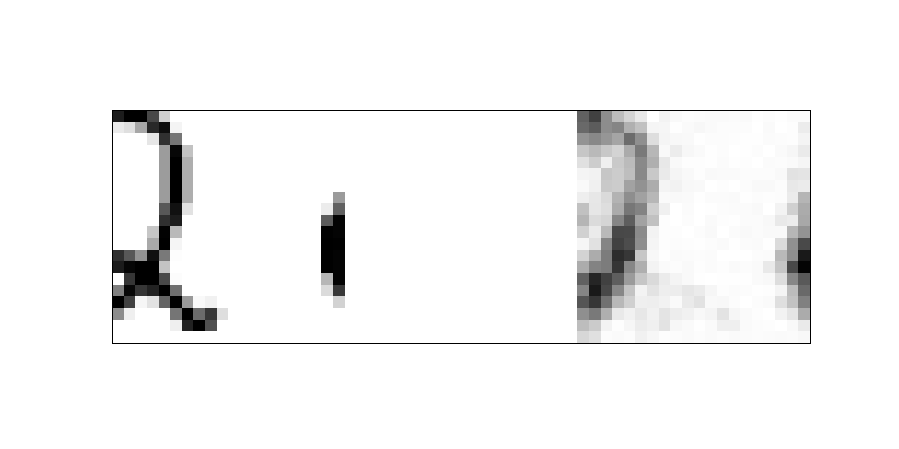

100%|██████████| 500/500 [00:02<00:00, 246.07it/s]


In [34]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

w_np = w.get()

ims = []
for i in tqdm(range(500)):
    v = ts_val[i].reshape(-1, 1)
    p = w_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w_np.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:20, :20] = v.reshape(20, 20)
    mini_tap[:20, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Ok!  It's pretty darn good.  As one final measure, I'm going to bump the number of winners up to 10, see how that does.

<IPython.core.display.Javascript object>


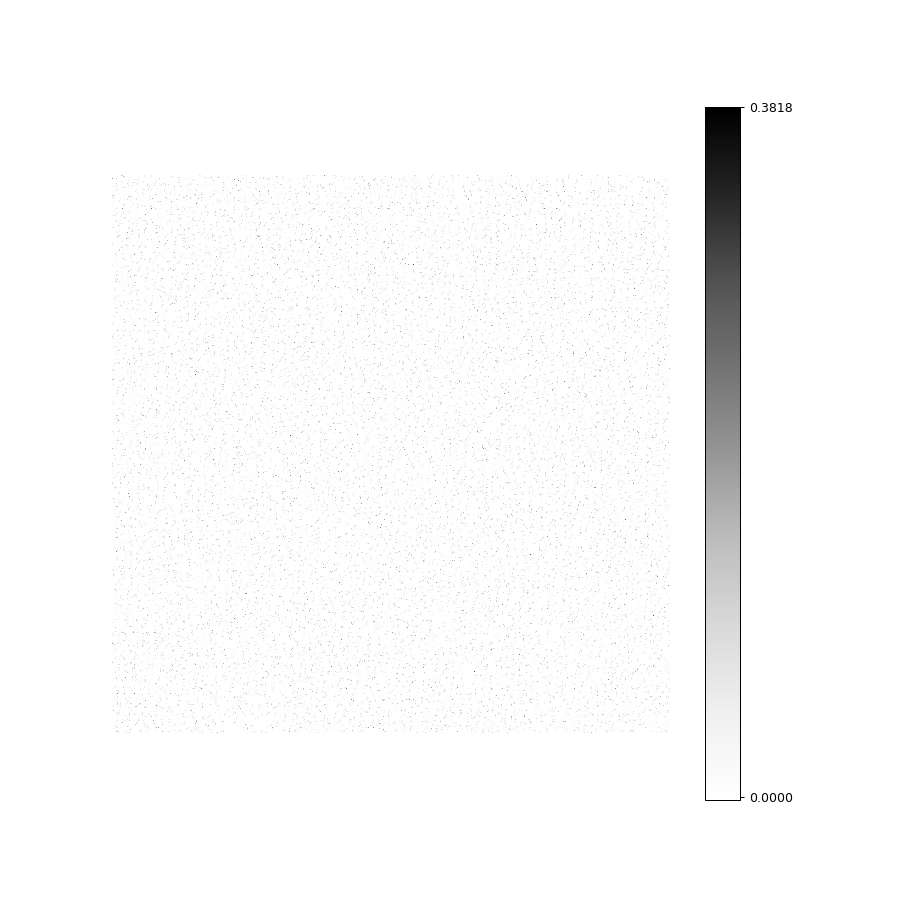

100%|██████████| 10000/10000 [00:08<00:00, 1237.41it/s]


In [35]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10_000

Kx = 100
Ky = 100
N = Kx * Ky
m_len = sl ** 2
tr_len = img_count

prec = 1e-10

n_w = 10 #Number of winners

# Feedforward
w = cp.random.uniform(0, 0.2, (N, m_len))
xi = 0.05

for ep in range(Nep):
    inputs = gp_data[np.random.permutation(T_s * 10)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        
    draw_weights(w.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


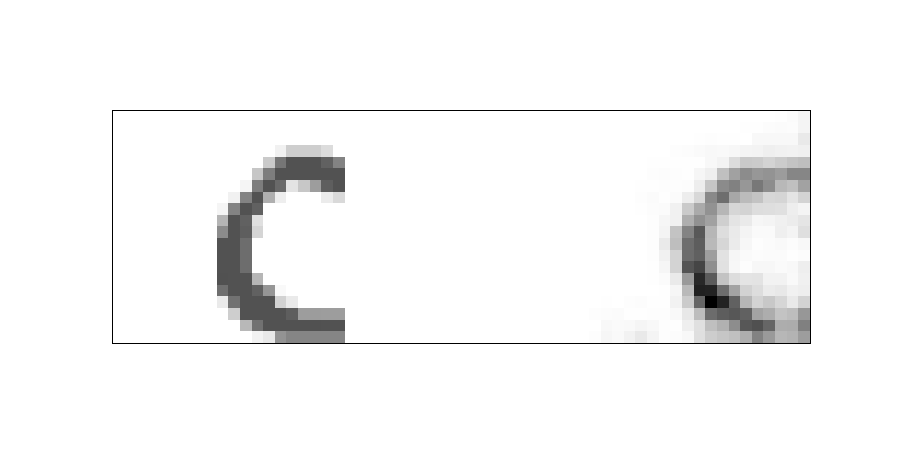

100%|██████████| 500/500 [00:02<00:00, 228.47it/s]


In [36]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

w_np = w.get()

ims = []
for i in tqdm(range(500)):
    v = ts_data[i].reshape(-1, 1)
    p = w_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w_np.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:20, :20] = v.reshape(20, 20)
    mini_tap[:20, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

<IPython.core.display.Javascript object>


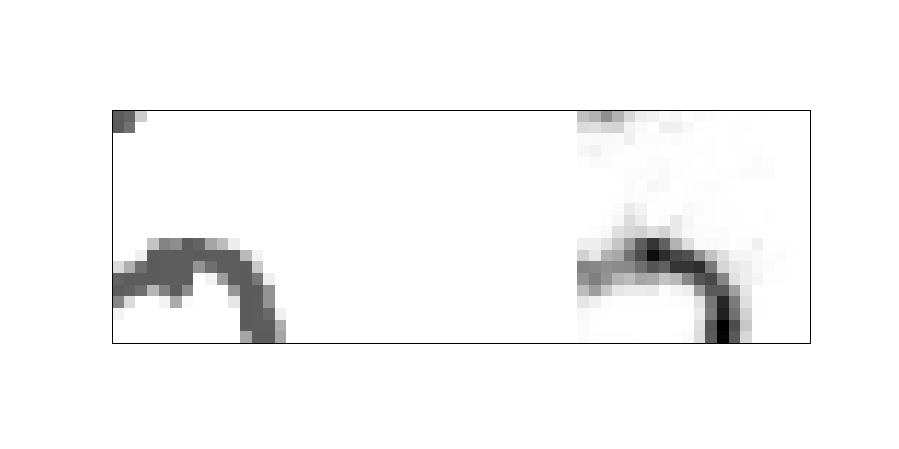

100%|██████████| 500/500 [00:02<00:00, 229.24it/s]


In [37]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

w_np = w.get()

ims = []
for i in tqdm(range(500)):
    v = ts_val[i].reshape(-1, 1)
    p = w_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((N, 1))
    mask[winners] = 1
    o = mask * p
    r = w_np.T @ o
    
    mini_tap = np.zeros((20, 60))
    
    mini_tap[:20, :20] = v.reshape(20, 20)
    mini_tap[:20, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=150, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Ok, I actually think it might be slightly better with 5 winners.  However, that doesn't really matter.  Time to close this bad boi down.

## Conclusions

AWS is dope, GPUs are dope, CuPy is dope, my life is dope.  But seriously, it's actually fantastic that this is working so incredibly well. By that I mean fast.  It's amazing that I can train a 10,000 neuron network this quickly, and get that level of performance.

So yeah, time to figure out invariance.

## Next steps

The invariant layer.  I must implement the invariant layer.  

Just as a quick thing before I wrap this up, I just kinda want to see how fast I can run Krotov and Hopfield's algorithm, and what kind of accuracy I can get with 100,000 neurons.

In [38]:
def wta_classification(w, T_s):
    flat_x = np.reshape(train_X, [-1, L])
    flat_test = np.reshape(test_X, [-1, L])
    
    v = flat_x[:T_s]
    train_lbls = train_y[:T_s]
    
    v = v / np.array([np.linalg.norm(v, axis=1)]).T
    w = w / np.array([np.linalg.norm(w, axis=1)]).T
    
    wins = np.argmax(w[:, :L] @ (flat_x[:T_s, :]).T, axis=0)
    
    n_wins = np.zeros((w.shape[0], 10))
    
    for (n_i, lbl) in zip(wins, train_lbls):
        n_wins[n_i][lbl] += 1
        
    n_cls = np.argmax(n_wins, axis=1)
    print("Neuron classes:", n_cls)
    
    num_test = test_y.shape[0]
    test_v = flat_test / np.array([np.linalg.norm(flat_test, axis=1)]).T
    
    num_correct = 0
    
    incorrect = np.zeros(10)
    
    for i in range(num_test):
        w_mul_v = w[:, :L] @ test_v[i].T
        
        n_max = np.argmax(w_mul_v)
        
        pre = n_cls[n_max]
        if pre == test_y[i]:
            num_correct += 1
        else:
            incorrect[test_y[i]] += 1
            
    print("Accuracy:", str(num_correct * 100 / num_test) + '%')
    print("Misclassifieds: ", incorrect)

In [42]:
def draw_weights_k(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:L].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()

In [39]:
L = 28 * 28   #Size of mnist in pixels
S = 60000     #Size of training set

(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X / 255.0

flat_x = np.reshape(train_X, [-1, L])
flat_test = np.reshape(test_X, [-1, L])

In [46]:
gp_flat_x = cp.asarray(flat_x)

<IPython.core.display.Javascript object>


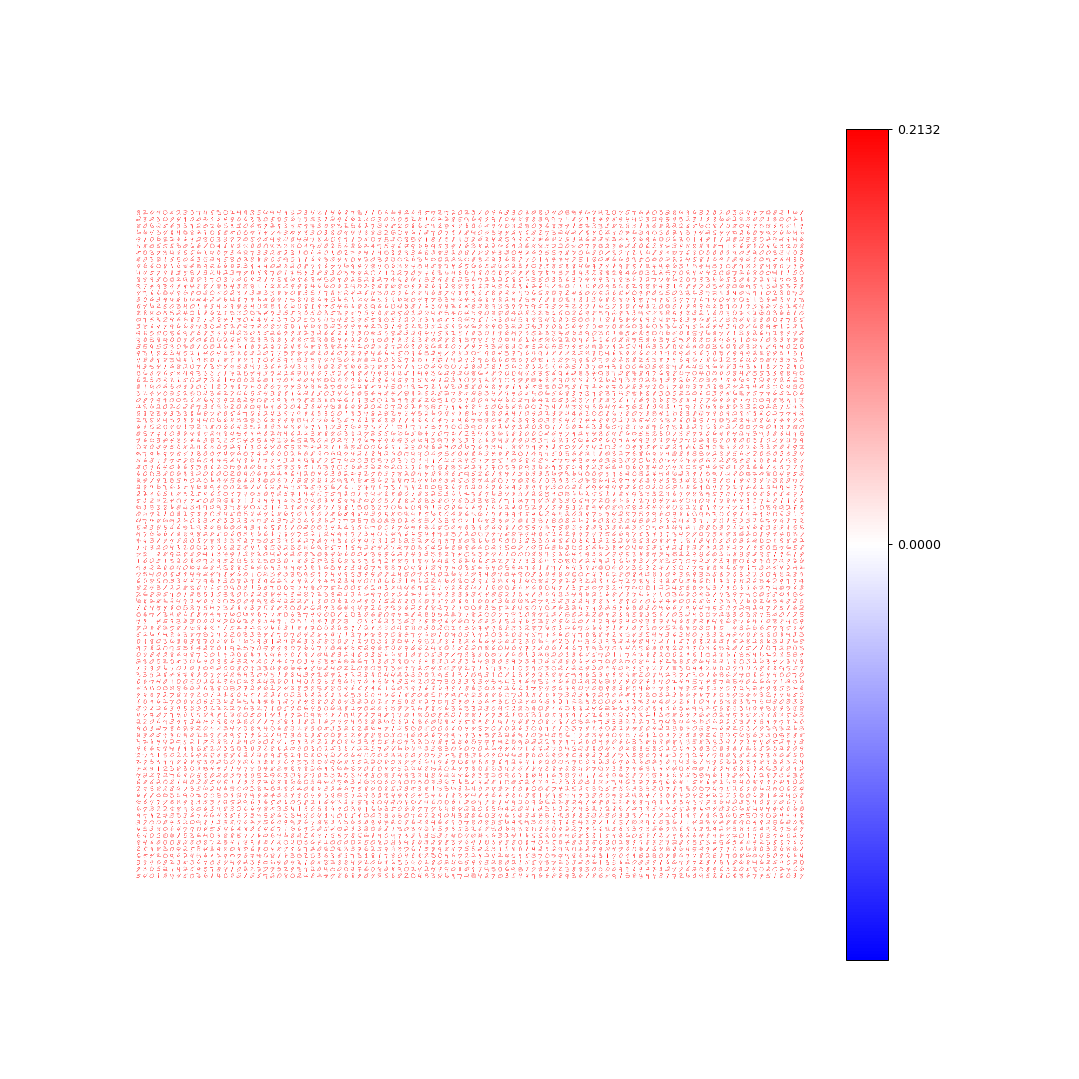

100%|██████████| 150/150 [00:00<00:00, 434.63it/s]


In [50]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

w_max = 1
Kx = 100
Ky = 100
xi = 0.01

N = Kx * Ky

Nep = 20
B = 400

T_s = 60000

w = cp.abs(cp.random.uniform(0, 0.5, (N, L)))

for ep in range(Nep):
    inputs = gp_flat_x[cp.random.permutation(S)]
    
    for i in tqdm(range(T_s//B)): 
        v = inputs[i * B: (i + 1) * B]
        
        o = w @ v.T
        
        wins = cp.argmax(o, axis=0)
        
        win_mask = cp.zeros((N, B))
        win_mask[wins, cp.arange(B)] = 1
        win_mask = (win_mask / cp.maximum(cp.sum(win_mask, axis=1), 1).reshape(-1, 1))

        win_avg = (cp.sum(o * win_mask, axis=1)).reshape(-1, 1)

        v_update = win_mask @ v

        w += (v_update - (win_avg * w)) * xi
        
    draw_weights_k(w.get(), Kx, Ky)

In [52]:
wta_classification(w.get(), T_s)

Neuron classes: [3 2 4 ... 0 3 7]
Accuracy: 96.21%
Misclassifieds:  [ 8.  7. 40. 43. 39. 40. 17. 50. 68. 67.]


Shoot dang!  I didn't get above 96.21%  But actually wait.

Oh, hold up.  I was going to do wta on `flat_x`, but I forgot that 100 * 100 = 10,000 < 60,000.  So that would have taken a super long time.

...but maybe not with CuPy...

In [59]:
def wta_classification_c(w, T_s):    
    flat_x = cp.asarray(np.reshape(train_X, [-1, L]))
    flat_test = cp.asarray(np.reshape(test_X, [-1, L]))
    
    v = flat_x[:T_s]
    train_lbls = train_y[:T_s]
    
    v = v / cp.array([np.linalg.norm(v, axis=1)]).T
    w = w / cp.array([np.linalg.norm(w, axis=1)]).T
    
    wins = cp.argmax(w[:, :L] @ (flat_x[:T_s, :]).T, axis=0)
    
    n_wins = cp.zeros((w.shape[0], 10))
    
    for (n_i, lbl) in tqdm(zip(wins, train_lbls)):
        n_wins[n_i][lbl] += 1
        
    n_cls = cp.argmax(n_wins, axis=1)
    print("Neuron classes:", n_cls)
    
    num_test = test_y.shape[0]
    test_v = flat_test / cp.array([cp.linalg.norm(flat_test, axis=1)]).T
    
    num_correct = 0
    
    incorrect = cp.zeros(10)
    
    for i in tqdm(range(num_test)):
        w_mul_v = w[:, :L] @ test_v[i].T
        
        n_max = cp.argmax(w_mul_v)
        
        pre = n_cls[n_max]
        if pre == test_y[i]:
            num_correct += 1
        else:
            incorrect[test_y[i]] += 1
            
    print("Accuracy:", str(num_correct * 100 / num_test) + '%')
    print("Misclassifieds: ", incorrect)

In [60]:
wta_classification_c(w, T_s)

60000it [00:05, 11736.93it/s]
  3%|▎         | 283/10000 [00:00<00:03, 2828.53it/s]

Neuron classes: [0 0 0 ... 0 0 0]


100%|██████████| 10000/10000 [00:03<00:00, 2838.89it/s]

Accuracy: 9.8%
Misclassifieds:  [   0. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]


In [61]:
wta_classification_c(cp.asarray(flat_x), T_s)

OutOfMemoryError: Out of memory allocating 28,800,000,000 bytes (allocated so far: 7,430,924,800 bytes).

Ok, that's it for the current experiment!  See y'all next time!